In [1]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [7]:
with open('bowtransformer.sav', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    bow_transformer = u.load()
    
with open('tfidf.sav', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    tfidf_transformer = u.load()
    
with open('real_fake_model.sav', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    real_fake_model = u.load()
    
with open('naivepipeline.sav', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    pipeline = u.load()

C:\Users\100707881\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\100707881\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\100707881\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.19.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\100707881\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.2 when using version 0.23.1. This might lead to breaking code or inva

## Part 1: Import dataset

In [2]:
# Entire dataset
news = pd.read_csv('truefake.csv')

In [8]:
news.head()

,r_or_f,title,text,subject,date
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [9]:
# There are some duplicate texts, blanks, and ones with one space.
news.describe().transpose()

,count,unique,top,freq
r_or_f,44919,2,Fake,23502
title,44919,38740,Factbox: Trump fills top jobs for his administ...,14
text,44919,38657,,627
subject,44898,19,politicsNews,11272
date,44898,1027,20-Dec-17,197


In [10]:
# Dropped null values, title-only rows, and duplicates
news.dropna(inplace=True)
news = news[news.text != ' ']
news = news.drop_duplicates(subset='text', keep='last')

In [11]:
# 38645 articles remain
news.describe().transpose()

,count,unique,top,freq
r_or_f,38645,2,Real,21191
title,38645,38269,Factbox: Trump fills top jobs for his administ...,14
text,38645,38645,Here s what Politico s headline today looked l...,1
subject,38645,19,politicsNews,11202
date,38645,1027,6-Dec-17,177


## Part 2: Text preprocessing

In [2]:
# Packages for removing punctuation, stopwords, non-ASCII characters
import string
from nltk.corpus import stopwords
import re

In [3]:
# Combining non-ascii, punctuation, and stopword removal
def text_process(text):
    """
    1. remove non-ascii characters (â, €, ™, œ)
    2. remove punctuation
    3. remove stop words
    4. return list of lowercase clean text words
    """
    ascii_only = re.sub(r'[^\x00-\x7f]',r'', text)
    
    nopunc = [char for char in ascii_only if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [12]:
# Using text_process
print(news.loc[[0]]['text'].iloc[0][:500])
has_dirty = news.loc[[0]]['text'].iloc[0]
print('_' * 50)

no_dirty = text_process(has_dirty)
print(no_dirty[:100])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€œfiscal conservativeâ€ on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€œFace the Nation,â€ drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When 
__________________________________________________
['washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'us', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', '2018', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', '

## Part 3: Model creation

In [5]:
# Import functions needed for model creation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(news['text'], news['r_or_f'], test_size=0.3, random_state=42)

In [14]:
# Bag of words transformer
bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train)
pickle.dump(bow_transformer, open('bowtransformer.sav', 'wb'))

In [15]:
# Example bag of words
print(bow_transformer.transform([news['text'][0]]))
bow0 = bow_transformer.transform([news['text'][0]])

  (0, 387)	2
  (0, 759)	1
  (0, 1655)	2
  (0, 2977)	1
  (0, 6030)	3
  (0, 7292)	1
  (0, 8322)	1
  (0, 9344)	1
  (0, 9824)	2
  (0, 10332)	1
  (0, 12303)	1
  (0, 12592)	1
  (0, 12912)	2
  (0, 14232)	1
  (0, 14422)	3
  (0, 14439)	1
  (0, 16101)	1
  (0, 16224)	3
  (0, 17108)	2
  (0, 19196)	1
  (0, 19240)	1
  (0, 20100)	1
  (0, 20776)	1
  (0, 20778)	1
  (0, 22429)	1
  :	:
  (0, 169339)	1
  (0, 170350)	1
  (0, 170392)	4
  (0, 170541)	1
  (0, 173118)	3
  (0, 173246)	1
  (0, 173740)	2
  (0, 173905)	2
  (0, 173935)	2
  (0, 174321)	2
  (0, 174782)	1
  (0, 175254)	2
  (0, 175341)	1
  (0, 175633)	1
  (0, 175641)	1
  (0, 175956)	1
  (0, 176112)	1
  (0, 176442)	1
  (0, 176920)	1
  (0, 177020)	1
  (0, 178117)	1
  (0, 178588)	3
  (0, 179740)	3
  (0, 180053)	1
  (0, 180363)	1


In [74]:
# Each index corresponds to a word
bow_transformer.get_feature_names()[180363]

'young'

In [17]:
# Transform articles to bag of words
news_bow = bow_transformer.transform(X_train)

In [18]:
# TF/IDF using sklearn's TF/IDF transformer
tfidf_transformer = TfidfTransformer().fit(news_bow)
pickle.dump(tfidf_transformer, open('tfidf.sav', 'wb'))

In [17]:
# Example of TF/IDF weight value for each word vs actual document
print(tfidf_transformer.transform(bow0))

  (0, 180363)	0.030398092116573194
  (0, 180053)	0.02507976965994357
  (0, 179740)	0.055917615413592185
  (0, 178588)	0.03847459421928776
  (0, 178117)	0.022394946098048887
  (0, 177020)	0.03447643169921871
  (0, 176920)	0.05968381256106408
  (0, 176442)	0.018808504605152165
  (0, 176112)	0.04299722265365182
  (0, 175956)	0.025790498157697968
  (0, 175641)	0.020691617802734985
  (0, 175633)	0.044023615138644896
  (0, 175341)	0.03466611673066019
  (0, 175254)	0.042664344437372256
  (0, 174782)	0.02033783836023155
  (0, 174321)	0.03548973022182632
  (0, 173935)	0.053551113762988586
  (0, 173905)	0.04312838989445077
  (0, 173740)	0.05951951240054764
  (0, 173246)	0.030483034865893
  (0, 173118)	0.09430776808992423
  (0, 170541)	0.024025309812115092
  (0, 170392)	0.05196480534995552
  (0, 170350)	0.031953636130520366
  (0, 169339)	0.017689091058032687
  :	:
  (0, 22429)	0.01995387902988239
  (0, 20778)	0.038192101852072086
  (0, 20776)	0.04862866268324909
  (0, 20100)	0.046817559875251664


In [20]:
# Transform train set
news_tfidf = tfidf_transformer.transform(news_bow)

In [21]:
# Now messages are vectorized, create naive bayes model
real_fake_model = MultinomialNB().fit(news_tfidf, y_train)
pickle.dump(real_fake_model, open('real_fake_model.sav', 'wb'))

In [20]:
# Predict an article--bad practice since this is from train set.
# To predict a test set article, we'd have to preprocess it first
# Can streamline process with data pipeline
real_fake_model.predict(bow0)[0]

b'Real'

## Part 4: Data pipeline

In [6]:
# Create data pipeline to streamline process
from sklearn.pipeline import Pipeline

In [13]:
# Label, algorithm
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [14]:
# Pipeline is an estimator, fits and trains in one line
# Again, takes a while even for 500 articles only
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f506a2017d0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [26]:
# Test on test set
predictions = pipeline.predict(X_test)

In [64]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
# Accuracy of 92%
print(classification_report(y_test,predictions))

               precision      recall    f1-score   support

        Fake        0.98        0.85        0.91      5256
        Real        0.89        0.99        0.94      6338

    accuracy                                0.92     11594
   macro avg        0.93        0.92        0.92     11594
weighted avg        0.93        0.92        0.92     11594


In [66]:
# Look towards minimizing false negatives
print(confusion_matrix(y_test,predictions))

[[4460   796]
 [  64  6274]]


## Part 5: Save model

In [5]:
filename = 'naivepipeline.sav'

In [16]:
# Save model
pickle.dump(pipeline, open(filename, 'wb'))

In [6]:
# Load model
# pipeline = pickle.load(open(filename, 'rb'))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe3 in position 0: ordinal not in range(128)

## Part 6: Predict novel article

In [11]:
new_article = [input("Please enter article: ")]
score = pipeline.predict_proba(new_article)[0][0]
real_score = round((1-score)*100.0,2)
fake_score = round((score)*100.0,2)
print(f"\nReal: {real_score}% \nFake: {fake_score}%")
print(f"\nResult: {str(pipeline.predict(new_article)[0])[1:]}")

Please enter article: This is a rapidly evolving situation. The information in this story was last updated at 3 p.m. on Nov. 29. How many cases? The Durham Region Health Department reported 21 new cases of COVID-19 on Nov. 29. There are 218 active cases and a total of 28,107 cases have been reported since the start of the pandemic. How many cases are resolved? In Durham, 27,500 cases of COVID-19 are resolved. How many are hospitalized? In Durham there are six patients hospitalized with COVID-19 as of Nov. 29, one of whom is in intensive care. How many have died? Durham has reported 389 deaths from COVID-19 as of Nov. 29 -- 227 of the total deaths in Durham were residents of long-term care or retirement homes.

Real: 80.86% 
Fake: 19.14%

Result: 'Real'


### Article 1
Caught in a sticky situation, Canada is tapping into its maple syrup reserves.
The Quebec Maple Syrup Producers said it will release about 50 million pounds from its strategic maple syrup reserves — nearly half its stockpile — in an effort to overcome a global shortage.
The shortage is being blamed on less-than-ideal weather conditions. An unusually short and warm spring soured what is typically a sweet harvest.
“That’s why the reserve is made, to never miss maple syrup,” spokesperson Helene Normandin, of the  Maple Syrup Producers, told NPR.
The government-supported organization uses its reserves to control syrup prices and supply. As of 2020, Quebec produced 73% of all maple syrup in the world.
Its biggest customer of liquid gold is the U.S., which accounts for about 60% of Canada’s export volume.
Historically, 2021 was an average year for maple production in Quebec. An estimated 133 million pounds were harvested but sales rose to 21% compared to last year, creating the supply shortage.

### Article 2
OTTAWA – An independent study tracking how our elected Members of Parliament spend their day has found that, in average work week, the majority of an MPs time is spent sitting at their desk, thinking about how, when and where they would punch Pierre Poilievre right in the face.
“Going in we assumed MPs spend most of their time considering legislation or doing work for their constituents,” said lead researcher Dr. Helen Paley. “But turns out it’s just imagining what it must feel like to interrupt one of his preening speeches and sock him in the kisser.”
“Plus of course imagining what cool line they would say right after, like ‘maybe you won’t sound so nasal now’ or ‘the CBC says hello’.”
There were some differences amongst the parties. NDP and Liberal MPs spend nearly 60% of their day thinking about hitting Poilievre, while Conservative MPs spend only 51%. However, in the case of Conservative Party Leader Erin O’Toole, the number often reaches as high as 98%.
“I would never physically strike a fellow member of parliament, let’s be clear about that,” said one MP who wished to go unnamed. “But I can’t deny that when we’re in Question Period or a committee hearing I sometimes let my mind wander and it always ends up in the same place. My foot up his ass.”
The MP then adapted a wistful expression and his eyes unfocused as he looked off, clearly taking a moment. “Stay down Pierre,” he whispered to himself as a big smile broke out across his face.
The study also found that MPs spend a quarter of their day trying to figure out who cooked fish in the Parliamentary Microwave.

### Article 3
This is a rapidly evolving situation. The information in this story was last updated at 3 p.m. on Nov. 29.
How many cases?
The Durham Region Health Department reported 21 new cases of COVID-19 on Nov. 29. There are 218 active cases and a total of 28,107 cases have been reported since the start of the pandemic. 
How many cases are resolved?
In Durham, 27,500 cases of COVID-19 are resolved.
How many are hospitalized?
In Durham there are six patients hospitalized with COVID-19 as of Nov. 29, one of whom is in intensive care.
How many have died?
Durham has reported 389 deaths from COVID-19 as of Nov. 29 -- 227 of the total deaths in Durham were residents of long-term care or retirement homes. 

## Future Direction

In [51]:
# Add new columns for length of text and number of words
news['word_length'] = news['text'].apply(lambda x: len(x.split()))

In [52]:
# Fake news is generally longer both in character length and word count
news.groupby('r_or_f').mean()

,word_length
r_or_f,
Fake,421.207631
Real,384.979944


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD204600A0>,
      dtype=object)

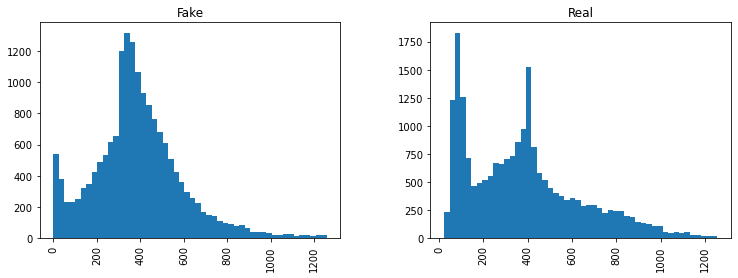

In [49]:
# Side-by-side histograms for word_length
# Both seem to have a bimodal distribution
# Can see more clearly that fake news is longer
inlier_news.hist(column='word_length',by='r_or_f',bins=50,figsize=(12,4))